In [ ]:
!pip install transformers[sentencepiece]
!pip install datasets
!pip install evaluate
!pip install seqeval
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 896.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 778.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=88eb45052699c080bbfcda4453b0f01030b32c8af34f16a83bb37ee5eca2778b
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from transformers import AutoModelForTokenClassification
import transformers
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer
import evaluate
from huggingface_hub import notebook_login
from tqdm.auto import tqdm

from torch.utils.data import DataLoader
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from huggingface_hub import Repository, get_full_repo_name

In [ ]:
notebook_login()

In [ ]:
dataset = load_dataset("go_emotions")

In [ ]:
labels_idxs = {}

for idx , label in enumerate(dataset['train']['labels']):

    for l in label:
        if l not in labels_idxs:
            labels_idxs[l] = []
        labels_idxs[l].append(idx)


#labels_idxs.keys()

In [ ]:
# prompt: how to count the number of unqiue digits in a list of list
from collections import Counter

dataset_n = dataset['train']['labels']
label_count = Counter([item for sublist in dataset_n for item in sublist])
label_count.values()

ratio = []
temp = 1.5
summation = sum(label_count.values())
for d in label_count.values():
  ratio.append((d/summation) ** (1/temp))

ratio_q = []
summation_q = sum(ratio)
# print(summation)
for q_i in ratio:
  ratio_q.append(q_i/summation_q)
ratio_q

temp_sample_output = {}
for id, (label, count) in enumerate(label_count.items()):
  temp_sample_output[label] = int(summation * ratio_q[id])
#temp_sample_output

In [ ]:
# prompt: how to count the number of unqiue digits in a list of list
from collections import Counter

dataset_n = dataset['train']['labels']
label_count = Counter([item for sublist in dataset_n for item in sublist])
label_count.values()

ratio = []
temp = 3
summation = sum(label_count.values())
for d in label_count.values():
  ratio.append((d/summation) ** (1/temp))

ratio_q = []
summation_q = sum(ratio)
# print(summation)
for q_i in ratio:
  ratio_q.append(q_i/summation_q)
ratio_q

temp_sample_output3 = {}
for id, (label, count) in enumerate(label_count.items()):
  temp_sample_output3[label] = int(summation * ratio_q[id])
#temp_sample_output

In [ ]:
# temp_sample_output

In [ ]:
import random
random.seed(42)
index_select = []
for label, temp_count in temp_sample_output.items():
  count = 0
  while count < temp_count:
    list_idx = labels_idxs[label]
    index_select.append(random.choice(list_idx))
    count += 1

In [ ]:
import random
random.seed(42)
index_select3 = []
for label, temp_count in temp_sample_output3.items():
  count = 0
  while count < temp_count:
    list_idx = labels_idxs[label]
    index_select3.append(random.choice(list_idx))
    count += 1

In [ ]:
# print(dataset)
dataset['train']['labels']


LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]

id2label = {idx:label for idx, label in enumerate(LABELS)}
label2id = {label:idx for idx, label in enumerate(LABELS)}

# print(id2label)

In [ ]:
sorted_label_count = sorted(label_count.items(), key=lambda x: x[1], reverse=True)
freq =[i[1] for i in sorted_label_count]
label = [id2label[i[0]] for i in sorted_label_count]

In [ ]:
sorted_temp_sample_output =sorted(temp_sample_output.items(), key=lambda x: x[1], reverse=True)
freq_temp =[i[1] for i in sorted_temp_sample_output]
label_temp = [i[0] for i in sorted_temp_sample_output]

In [ ]:
sorted_temp_sample_output3 =sorted(temp_sample_output3.items(), key=lambda x: x[1], reverse=True)
freq_temp3 =[i[1] for i in sorted_temp_sample_output3]

In [ ]:
freq_temp

[8103,
 3554,
 2833,
 2652,
 2522,
 2425,
 2329,
 2254,
 2207,
 1873,
 1862,
 1770,
 1701,
 1666,
 1618,
 1480,
 1459,
 1435,
 1241,
 1182,
 1026,
 977,
 921,
 622,
 413,
 394,
 318,
 249]

In [ ]:
temp_sample_output

{27: 8103,
 2: 1862,
 14: 977,
 3: 2522,
 26: 1435,
 15: 2652,
 8: 1026,
 20: 1873,
 0: 3554,
 6: 1701,
 1: 2425,
 4: 2833,
 5: 1459,
 12: 622,
 22: 1480,
 9: 1618,
 16: 249,
 25: 1666,
 7: 2329,
 17: 1770,
 18: 2254,
 13: 1241,
 10: 2207,
 24: 921,
 11: 1182,
 23: 394,
 21: 318,
 19: 413}

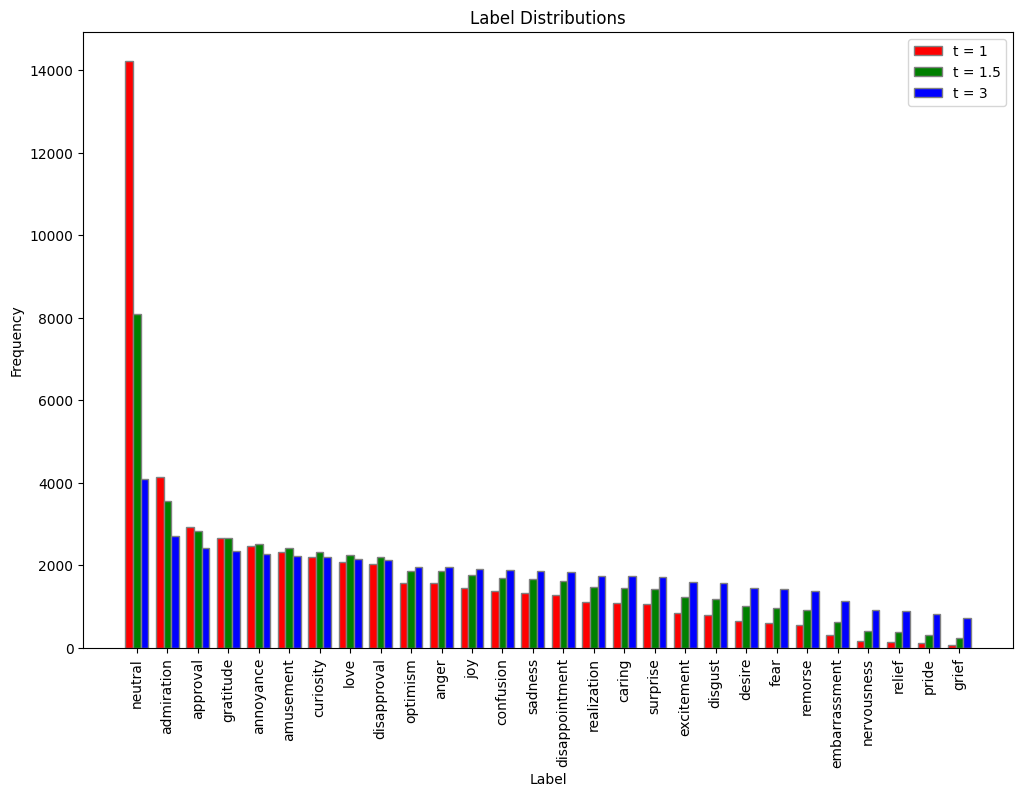

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
IT = [12, 30, 1, 8, 22]
ECE = [28, 6, 16, 5, 10]
CSE = [29, 3, 24, 25, 17]

# Set position of bar on X axis
br1 = np.arange(len(freq))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, freq, color ='r', width = barWidth,
		edgecolor ='grey', label ='t = 1')
plt.bar(br2, freq_temp, color ='g', width = barWidth,
		edgecolor ='grey', label ='t = 1.5')
plt.bar(br3, freq_temp3, color ='b', width = barWidth,
	    edgecolor ='grey', label ='t = 3')

# Adding Xticks
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([r + barWidth for r in range(len(freq))], label, rotation=90)
plt.title('Label Distributions')

plt.legend()
plt.show()


In [ ]:
sum(temp_sample_output.values())

51086

In [ ]:
len(index_select)

51086

In [ ]:
print(dataset)
dataset['train']['labels']


LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]

id2label = {idx:label for idx, label in enumerate(LABELS)}
label2id = {label:idx for idx, label in enumerate(LABELS)}

print(id2label)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


In [ ]:
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
def preprocess_function(examples):
  text = examples["text"]
  encoding = tokenizer(text, truncation=True)
  label_mat = np.zeros((len(text), len(LABELS))).astype(np.float32)
  for i in range(len(text)):
    for l in examples['labels'][i]:
      label_mat[i][l] = 1.0
  label_mat = [[float(i) for i in row]  for row in label_mat]
  encoding['labels'] = label_mat

  return encoding

tokenized_dataset = dataset.map(preprocess_function, batched=True)
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Cast type to float
from datasets import Value, Sequence, Features, ClassLabel
tokenized_dataset['train'] = tokenized_dataset['train'].select(index_select3)
print(tokenized_dataset['train'])
new_features = tokenized_dataset['train'].features.copy()
new_features["labels"] = Sequence(Value("float32"))
tokenized_dataset['train'] = tokenized_dataset['train'].cast(new_features)

new_features = tokenized_dataset['validation'].features.copy()
new_features["labels"] = Sequence(Value("float32"))
tokenized_dataset['validation'] = tokenized_dataset['validation'].cast(new_features)

new_features = tokenized_dataset['test'].features.copy()
new_features["labels"] = Sequence(Value("float32"))
tokenized_dataset['test'] = tokenized_dataset['test'].cast(new_features)

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 51088
})


Casting the dataset:   0%|          | 0/51088 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [ ]:
import evaluate
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score



# Adapted from https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels):
    threshold = 0.1
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    precision_macro_average = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_macro_average = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_macro_average,
               'precision': precision_macro_average,
               'recall': recall_macro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", problem_type="multi_label_classification",
    num_labels=28, id2label=id2label, label2id=label2id
)
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    load_best_model_at_end=True,
    push_to_hub=False,
    metric_for_best_model="f1",
    warmup_ratio = 0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1,Precision,Recall,Roc Auc,Accuracy
500,0.430000,0.186352,0.054806,0.039252,0.398394,0.508060,0.000000
1000,0.195200,0.148472,0.185445,0.166273,0.298062,0.616836,0.206045
1500,0.163600,0.124709,0.314803,0.232396,0.587654,0.749994,0.059160
2000,0.136000,0.108438,0.364072,0.263740,0.733112,0.815400,0.065610
2500,0.119800,0.102910,0.382808,0.281158,0.737780,0.825467,0.114449
3000,0.110600,0.100444,0.398065,0.294472,0.724441,0.824725,0.131036
3500,0.099100,0.102233,0.408870,0.303607,0.723295,0.826150,0.127534
4000,0.089800,0.099274,0.409634,0.304430,0.741149,0.835571,0.154073
4500,0.082300,0.094895,0.447706,0.351598,0.691978,0.815837,0.174161
5000,0.079700,0.097974,0.429775,0.324825,0.723426,0.826822,0.146517


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=31930, training_loss=0.035449682674996354, metrics={'train_runtime': 3153.1369, 'train_samples_per_second': 162.023, 'train_steps_per_second': 10.126, 'total_flos': 9638831777866368.0, 'train_loss': 0.035449682674996354, 'epoch': 10.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainer.save_model('/content/drive/MyDrive/saved4t3_real')

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/saved4t3_real')
model.to('cuda:0')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# print(dataset['test']['text'])
pred = []


for i in range(0, len(dataset['test']['text']), 8):
  test_dataset = tokenizer(dataset['test']['text'][i:(i+8)], return_tensors="pt", truncation=True, padding=True, max_length=30)

  test_dataset['input_ids'] = test_dataset['input_ids'].to('cuda:0')
  test_dataset['token_type_ids'] = test_dataset['token_type_ids'].to('cuda:0')
  test_dataset['attention_mask'] = test_dataset['attention_mask'].to('cuda:0')

  output = model(**test_dataset).logits
  pred.extend(output.cpu().detach().numpy())

pred = np.array(pred)


In [ ]:
true = tokenized_dataset['test']['labels']
multi_label_metrics(pred, true)




{'f1': 0.4859254375256924,
 'precision': 0.4461080584193229,
 'recall': 0.5430844591868526,
 'roc_auc': 0.7578306134672378,
 'accuracy': 0.35710337202874515}

In [ ]:
# {'f1': 0.47383898074073205,
#  'precision': 0.40032572404303357,
#  'recall': 0.5952037463333787,
#  'roc_auc': 0.7777564149314122,
#  'accuracy': 0.31748664086972544}

# {'f1': 0.48071053243677636,
#  'precision': 0.4295662361077882,
#  'recall': 0.55778441227023,
#  'roc_auc': 0.7639017027930526,
#  'accuracy': 0.3427307904919845}

# {'f1': 0.4859254375256924,
#  'precision': 0.4461080584193229,
#  'recall': 0.5430844591868526,
#  'roc_auc': 0.7578306134672378,
#  'accuracy': 0.35710337202874515}

In [ ]:
from sklearn.metrics import precision_score, recall_score

def multi_label_by_class(predictions, labels):
    threshold = 0.3
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    precision_list = []
    recall_list = []
    f1_list = []

    for i in range(len(y_pred[0])):
      precision_list.append(precision_score(np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
      recall_list.append(recall_score(np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
      f1_list.append(f1_score(y_true=np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
    return precision_list, recall_list, f1_list

precision_list, recall_list, f1_list = multi_label_by_class(pred, true)
f1_list

[0.658204895738894,
 0.8041958041958042,
 0.45098039215686275,
 0.2933753943217666,
 0.3517835178351783,
 0.39189189189189194,
 0.41399416909620995,
 0.5531914893617023,
 0.49079754601226994,
 0.30581039755351686,
 0.3573883161512027,
 0.4634146341463415,
 0.417910447761194,
 0.35042735042735046,
 0.6219512195121951,
 0.912981455064194,
 0.28571428571428575,
 0.6060606060606061,
 0.7736943907156674,
 0.2608695652173913,
 0.5492227979274611,
 0.4615384615384615,
 0.22471910112359547,
 0.43478260869565216,
 0.6338028169014085,
 0.5678233438485805,
 0.5442622950819672,
 0.5750778816199378]

In [ ]:
np.round(f1_list, 2)

array([0.66, 0.8 , 0.45, 0.29, 0.35, 0.39, 0.41, 0.55, 0.49, 0.31, 0.36,
       0.46, 0.42, 0.35, 0.62, 0.91, 0.29, 0.61, 0.77, 0.26, 0.55, 0.46,
       0.22, 0.43, 0.63, 0.57, 0.54, 0.58])

In [ ]:
np.mean(np.round(f1_list, 2))

0.49035714285714294

In [ ]:
header = ['Text', 'True_label', 'True_label_id', 'Pred_label', 'Pred_label_id'] + LABELS
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(pred)).cpu().detach().numpy()
text = dataset['test']['text']
true_label_id = [str(label_list) for label_list in dataset['test']['labels']]
true_label = [str([id2label[l] for l in label_list ]) for label_list in dataset['test']['labels']]
pred_label_id = [np.nonzero(prob >= 0.5)[0].tolist() for prob in probs]
pred_label = [str([id2label[l] for l in label_list ]) for label_list in pred_label_id]
pred_label_id = [str(label_list) for label_list in pred_label_id]
print(np.array(text).shape)

print(probs[0])

results = np.hstack([np.array(text).reshape(-1,1), np.array(true_label).reshape(-1,1), np.array(true_label_id).reshape(-1,1), np.array(pred_label).reshape(-1,1), np.array(pred_label_id).reshape(-1,1), probs])
results = np.vstack([[header], results])

# np.savetxt('GoEmotions_prediction_results_updated.tsv', results, delimiter = '\t', fmt = '%s')

(5427,)
[6.0547650e-06 6.1710757e-06 1.6516547e-05 2.7688063e-06 3.0714171e-05
 5.3264698e-06 7.1798631e-06 2.3190987e-04 5.9937520e-06 1.0882406e-05
 3.5185785e-05 2.7900545e-05 1.0537955e-06 6.0325554e-05 7.1429290e-06
 2.9498306e-06 1.4219609e-05 6.8964277e-05 5.5687786e-03 2.3729594e-06
 7.9320380e-06 5.6985408e-07 2.8318640e-05 7.3737345e-07 1.5706142e-02
 3.3296591e-01 1.1238399e-05 2.0875088e-04]


In [ ]:
for i in range(len(true_label[:5000])):
  print(text[i], true_label[i], pred_label[i])

I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett! ['sadness'] []
It's wonderful because it's awful. At not with. ['admiration'] ['admiration', 'disgust']
Kings fan here, good luck to you guys! Will be an interesting game to watch!  ['excitement'] ['optimism']
I didn't know that, thank you for teaching me something today! ['gratitude'] ['gratitude']
They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife. ['neutral'] ['neutral']
Thank you for asking questions and recognizing that there may be things that you don’t know or understand about police tactics. Seriously. Thank you. ['gratitude'] ['gratitude']
You’re welcome ['gratitude'] ['gratitude']
100%! Congrats on your job too! ['gratitude'] ['admiration', 'gratitude']
I’m sorry to hear that friend :(. It’s for the best most likely if she didn’t accept you for who you are ['remorse'] ['remorse']
Girlfriend weak as well, that jump was pathetic. ['

In [ ]:
conf_mat = np.zeros((28,28))
true_label_id = [eval(l)  for l in true_label_id]
pred_label_id = [eval(l)  for l in pred_label_id]


for i in range(len(true_label_id)):
  for tl in true_label_id[i]:  # List of true labels
    for pl in pred_label_id[i]: # List of predicted labels
      conf_mat[tl, pl] += 1

# print(conf_mat)

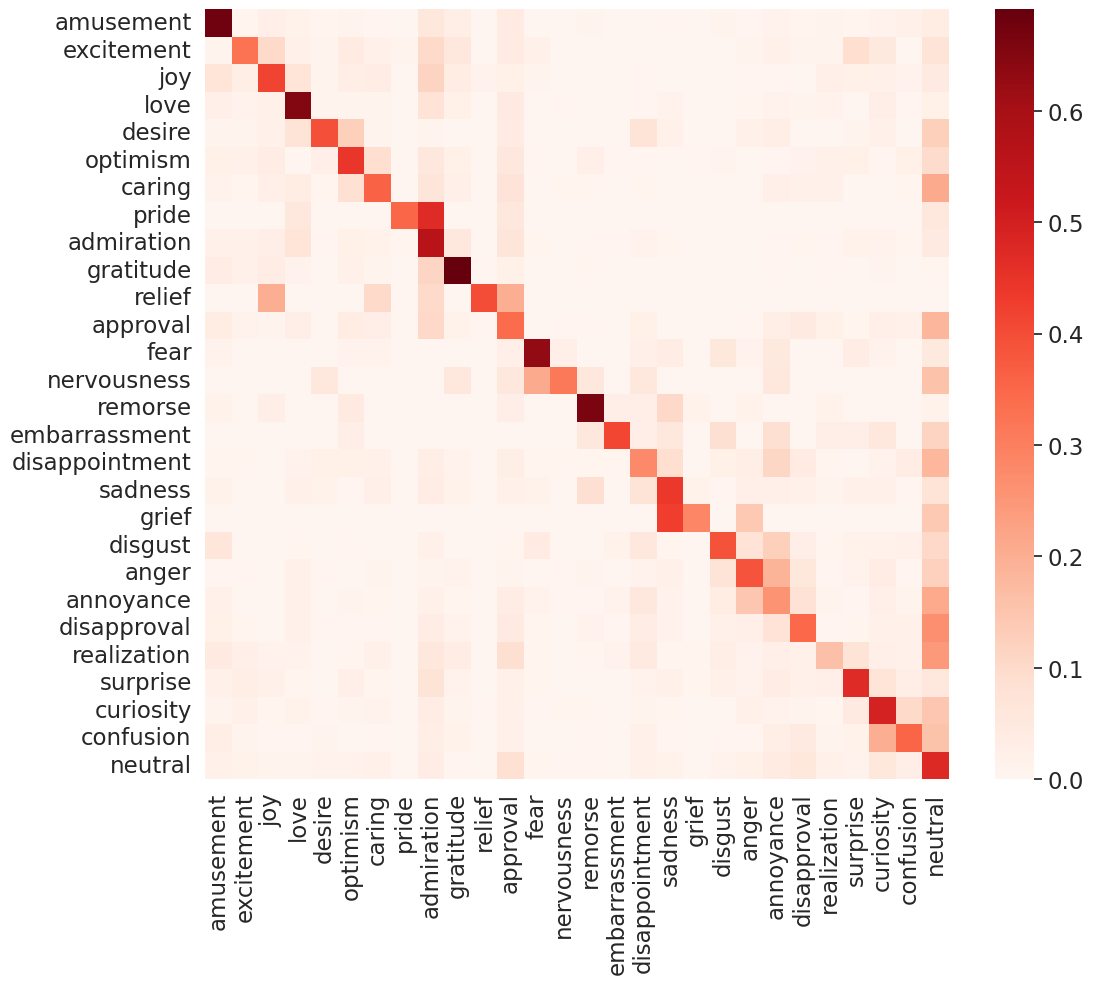

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

group = {
"positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
"negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
"ambiguous": ["realization", "surprise", "curiosity", "confusion"]
}

order = group["positive"] + group["negative"] + group["ambiguous"] + ['neutral']
ind = [label2id[i]  for i in order]

plt.figure(figsize = (12,10))
sns.set(font_scale=1.5)

conf_mat_plot = np.array(conf_mat / np.sum(conf_mat, axis = 1).reshape(-1,1))
conf_mat_plot = conf_mat_plot[ind][:,ind]
sns.heatmap(conf_mat_plot, cmap = 'Reds', xticklabels = np.array(LABELS)[ind], yticklabels = np.array(LABELS)[ind])

plt.savefig('confusion_matrix.pdf')


In [ ]:

conf_exp = conf_mat_plot
summary = [[np.sum(row[:12]), np.sum(row[12:23]), np.sum(row[23:27]), row[-1]] for row in conf_exp]


summary

np.mean(summary[12:23], axis = 0)

array([0.10319174, 0.72037355, 0.04544843, 0.13098628])

<ipython-input-190-82b5b67df820>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_labels = np.array(dataset['test']['labels'] + dataset['train']['labels'] + dataset['validation']['labels'])


63812
[16 21 23 19 12 24 14  8 11 13 26  5 22  9 25  6 17  2 20 18 10  7  1  3
 15  4  0 27]
[   96   142   182   208   375   669   764   801  1013  1052  1330  1375
  1382  1583  1625  1673  1785  1960  1976  2576  2581  2723  2895  3093
  3372  3687  5122 17772]


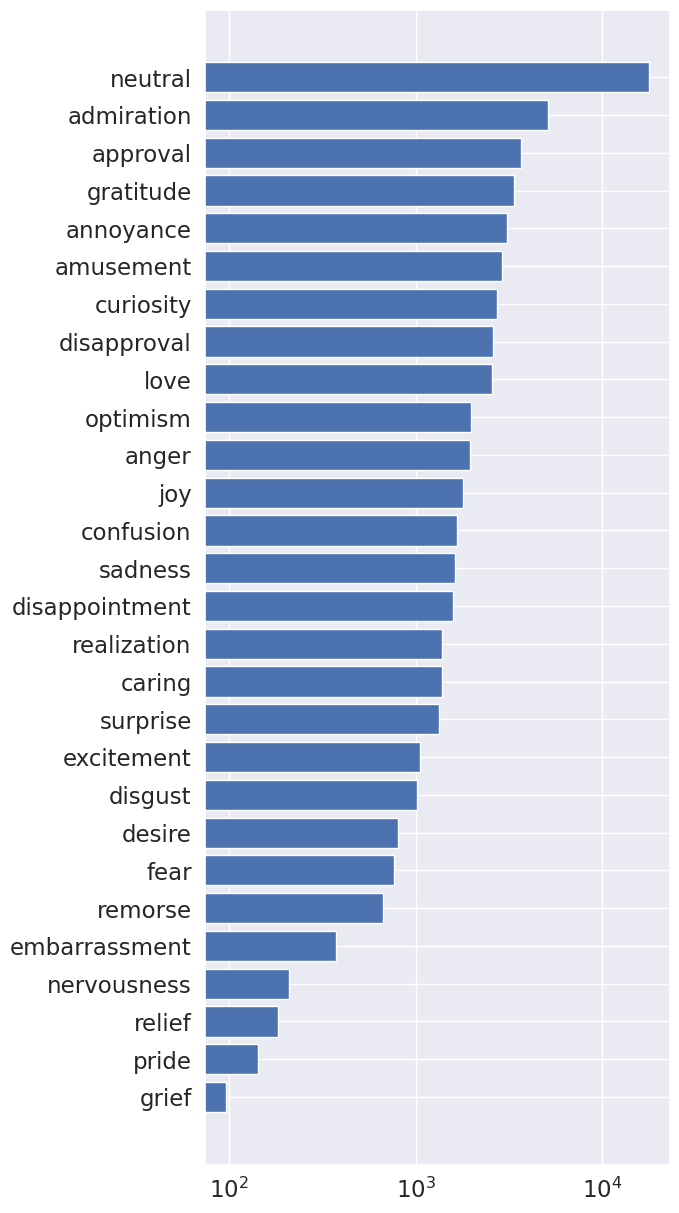

In [ ]:
all_labels = np.array(dataset['test']['labels'] + dataset['train']['labels'] + dataset['validation']['labels'])
all_labels = np.concatenate(all_labels)
print(len(all_labels))
labels_count = [np.sum(np.where(all_labels == l, 1, 0)) for l in range(0,28)]
ind = np.argsort(labels_count)
print(ind)
plt.figure(figsize = (6,15))
print(np.array(labels_count)[ind])
plt.barh(np.arange(28), np.array(labels_count)[ind], tick_label = np.array(LABELS)[ind], orientation = 'horizontal', log = True)
plt.savefig('label_distribution.pdf')
